In [1]:
!curl https://staffnet.kingston.ac.uk/~ku15565/CHASE_DB1/assets/CHASEDB1.zip -o CHASEDB1.zip
!mkdir data
!unzip -q CHASEDB1.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2455k  100 2455k    0     0   629k      0  0:00:03  0:00:03 --:--:--  629k


In [2]:
RAW_PATH = 'data/raw'
LABEL1_PATH = 'data/label1'    # 1st human expert
LABEL2_PATH = 'data/label2'    # 2nd human expert, useless

In [3]:
!mkdir $RAW_PATH $LABEL1_PATH $LABEL2_PATH
!mv data/*.jpg $RAW_PATH
!mv data/*1stHO.png $LABEL1_PATH
!mv data/*2ndHO.png $LABEL2_PATH

In [4]:
import pathlib
import numpy as np
import cv2 as cv
import tensorflow as tf

In [5]:
def preprocessing(image, is_gray=False):
    if is_gray:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        image = tf.expand_dims(image, -1)
        image = image / 255
        image = tf.image.resize(image, [960, 1024])
        image = np.where(image > 0.5, 1., 0.)
    else:
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = image / 255
        image = tf.image.resize(image, [960, 1024])
    return image

def load_images(image_path, is_gray=False):
    files = sorted(list(pathlib.Path(image_path).glob('*')))    # Please notice that the filename order is 1 by 1(pair)
    images = list(map(lambda f: cv.imread(str(f)), files))
    images = list(map(lambda img:preprocessing(img, is_gray), images))
    return np.array(images)

images = load_images(RAW_PATH)
labels = load_images(LABEL1_PATH, True)
print('RAW data shape:', images.shape)
print('LABEL data shape:', labels.shape)

RAW data shape: (28, 960, 1024, 3)
LABEL data shape: (28, 960, 1024, 1)


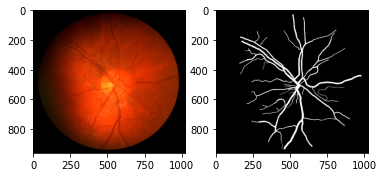

In [6]:
import matplotlib.pyplot as plt
plt.subplot(121)
plt.imshow(images[27])
plt.subplot(122)
plt.imshow(labels[27][..., 0], cmap='gray')

In [7]:
class ConvBlock(tf.keras.Model):
    def __init__(self, filters, name):
        super(ConvBlock, self).__init__(name=name)
        filters1, filters2 = filters

        self.conv1 = tf.keras.layers.Conv2D(filters1, 3, padding='same', name='conv1')
        self.conv2 = tf.keras.layers.Conv2D(filters2, 3, padding='same', name='conv2')

    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = tf.nn.relu(x)

        x = self.conv2(x)
        x = tf.nn.relu(x)

        return x

class UpConv(tf.keras.Model):
    def __init__(self, filter, name):
        super(UpConv, self).__init__(name=name)

        self.up = tf.keras.layers.UpSampling2D((2, 2), name='up')
        self.up_conv = tf.keras.layers.Conv2D(filter, 2, padding='same', name='up_conv')

    def call(self, input_tensor):
        x = self.up(input_tensor)
        x = self.up_conv(x)

        return x

inputs = tf.keras.layers.Input(shape=[960, 1024, 3], name='input')

block_1 = ConvBlock((64, 64), name='block_1')(inputs)
mp1 = tf.keras.layers.MaxPool2D(name='mp1')(block_1)

block_2 = ConvBlock((128, 128), name='block_2')(mp1)
mp2 = tf.keras.layers.MaxPool2D(name='mp2')(block_2)

block_3 = ConvBlock((256, 256), name='block_3')(mp2)
mp3 = tf.keras.layers.MaxPool2D(name='mp3')(block_3)

block_4 = ConvBlock((512, 512), name='block_4')(mp3)
mp4 = tf.keras.layers.MaxPool2D(name='mp4')(block_4)

block_5 = ConvBlock((1024, 1024), name='block_5')(mp4)
up1 = UpConv(512, name='up1')(block_5)
merge1 = tf.keras.layers.concatenate([block_4, up1], axis=3, name='merge1')

block_6 = ConvBlock((512, 512), name='block_6')(merge1)
up2 = UpConv(256, name='up2')(block_6)
merge2 = tf.keras.layers.concatenate([block_3, up2], axis=3, name='merge2')

block_7 = ConvBlock((256, 256), name='block_7')(merge2)
up3 = UpConv(128, name='up3')(block_7)
merge3 = tf.keras.layers.concatenate([block_2, up3], axis=3, name='merge3')

block_8 = ConvBlock((128, 128), name='block_8')(merge3)
up4 = UpConv(64, name='up4')(block_8)
merge4 = tf.keras.layers.concatenate([block_1, up4], axis=3, name='merge4')

block_9 = ConvBlock((64, 64), name='block_9')(merge4)
outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid', name='output')(block_9)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='U-Net')
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 960, 1024,   0           []                               
                                3)]                                                               
                                                                                                  
 block_1 (ConvBlock)            (None, 960, 1024, 6  38720       ['input[0][0]']                  
                                4)                                                                
                                                                                                  
 mp1 (MaxPooling2D)             (None, 480, 512, 64  0           ['block_1[0][0]']                
                                )                                                             

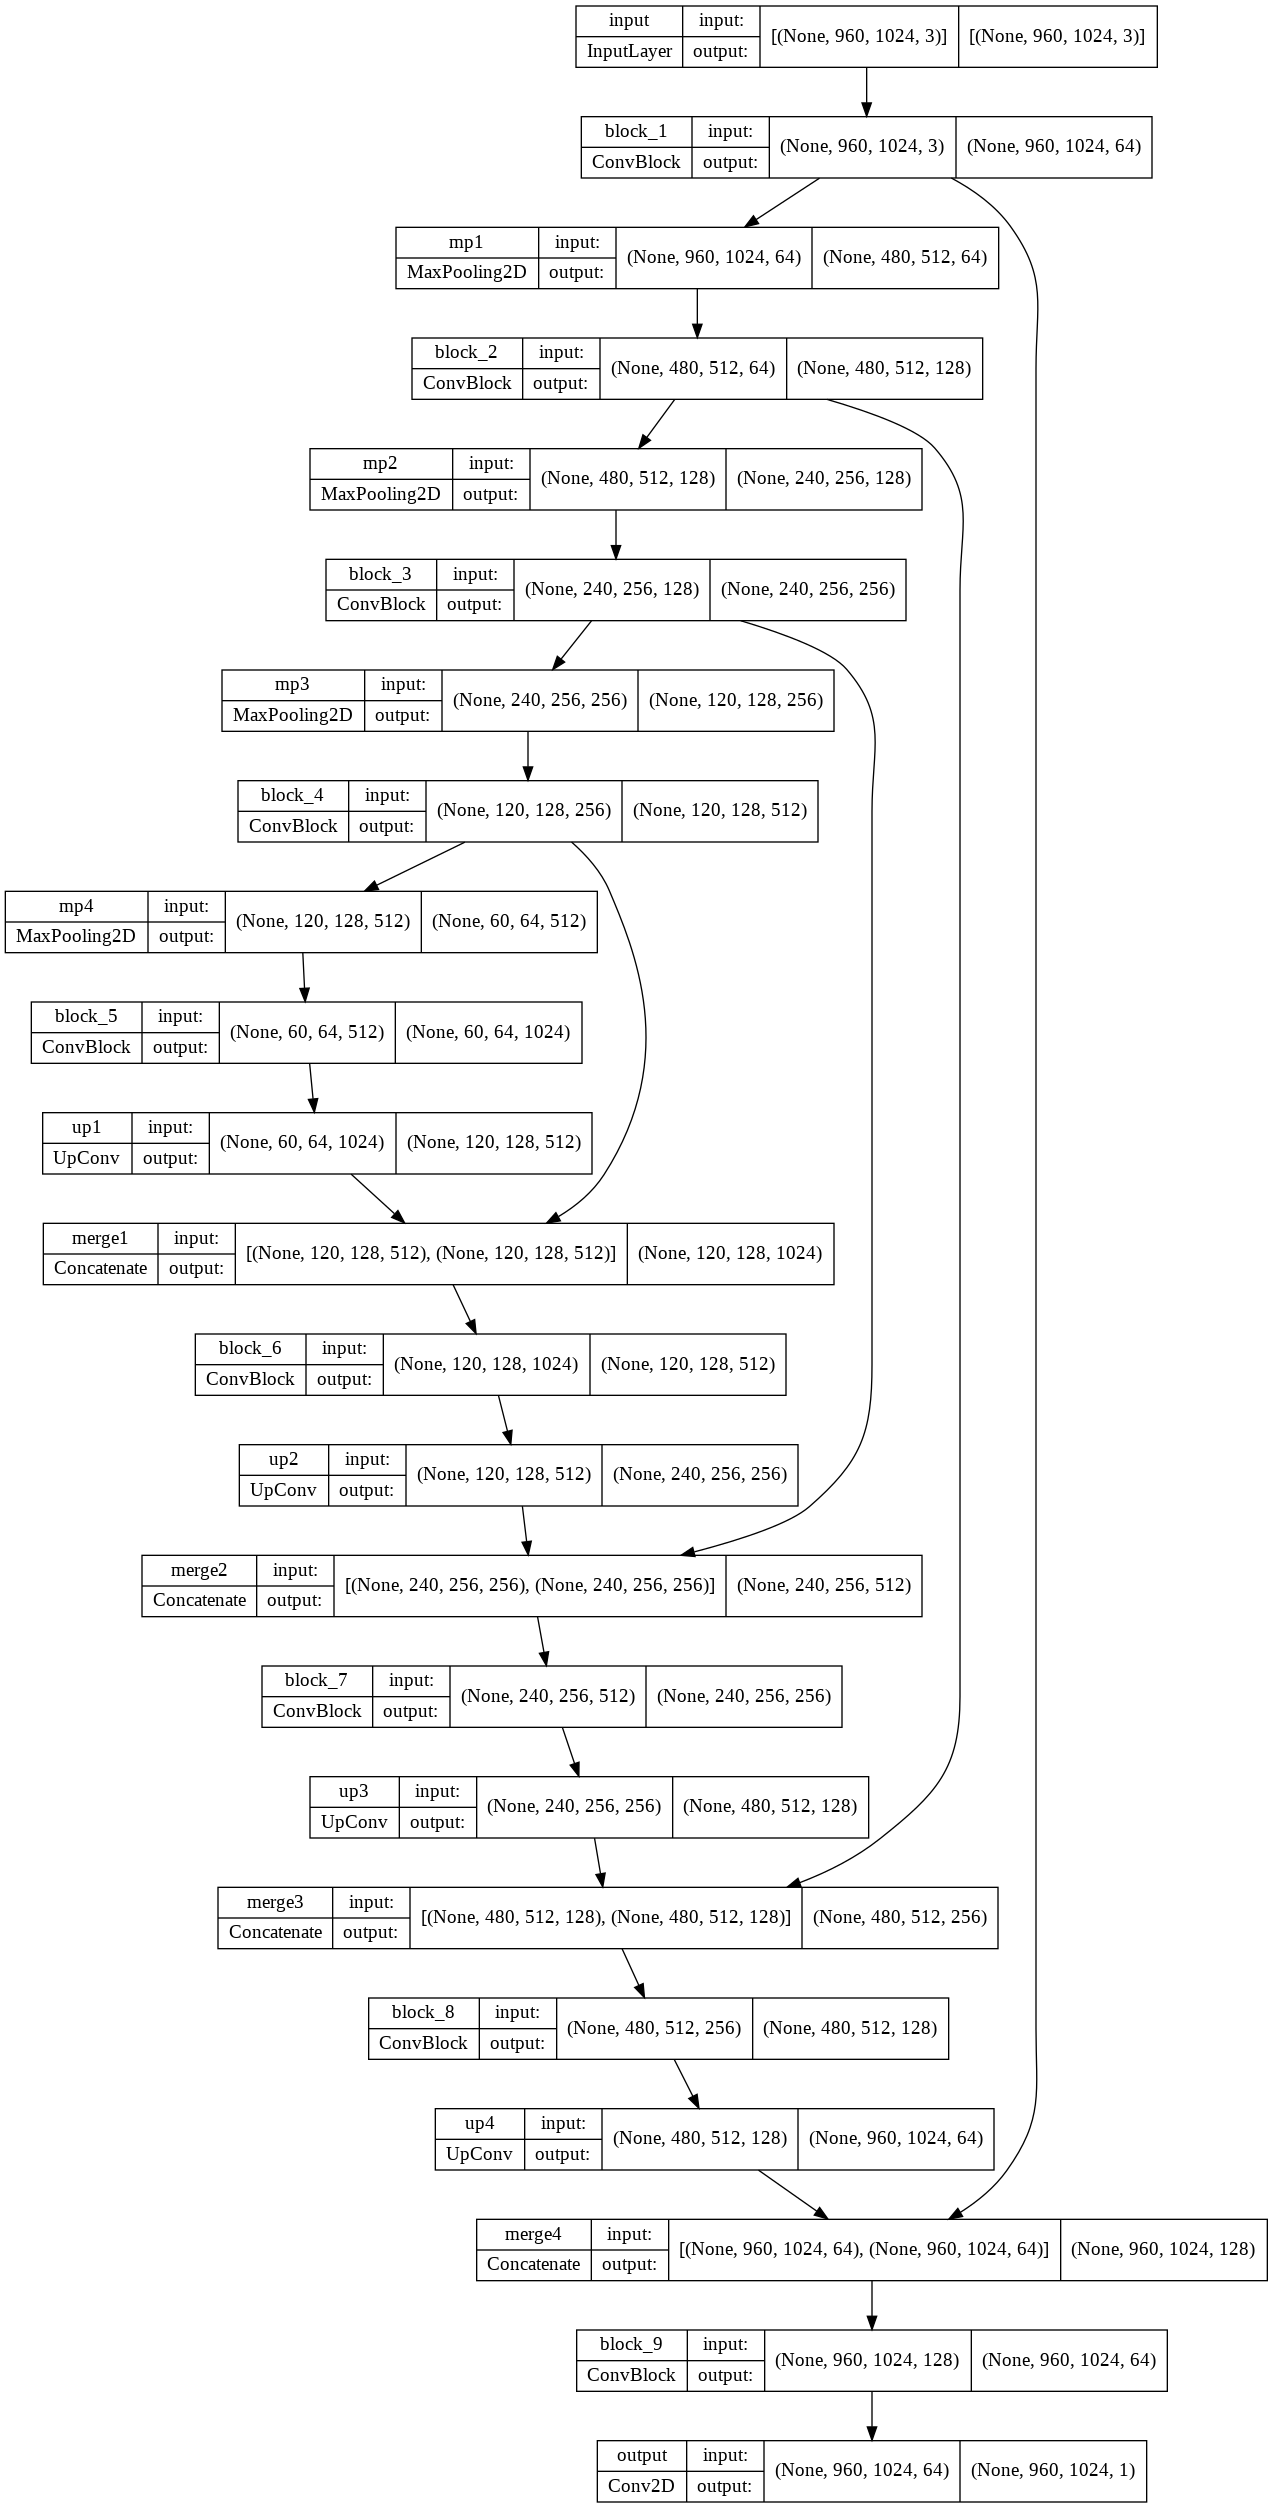

In [8]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
              loss=tf.keras.losses.BinaryCrossentropy())

model.fit(images, labels, epochs=30, batch_size=1)

Epoch 1/30
28/28 [==============================] - 131s 4s/step - loss: 0.3477
Epoch 2/30
28/28 [==============================] - 98s 3s/step - loss: 0.2310
Epoch 3/30
28/28 [==============================] - 98s 3s/step - loss: 0.2233
Epoch 4/30
28/28 [==============================] - 98s 3s/step - loss: 0.2203
Epoch 5/30
28/28 [==============================] - 98s 3s/step - loss: 0.2164
Epoch 6/30
28/28 [==============================] - 98s 3s/step - loss: 0.2139
Epoch 7/30
28/28 [==============================] - 98s 3s/step - loss: 0.2098
Epoch 8/30
28/28 [==============================] - 97s 3s/step - loss: 0.1997
Epoch 9/30
28/28 [==============================] - 98s 3s/step - loss: 0.2073
Epoch 10/30
28/28 [==============================] - 97s 3s/step - loss: 0.1919
Epoch 11/30
28/28 [==============================] - 97s 3s/step - loss: 0.1809
Epoch 12/30
28/28 [==============================] - 97s 3s/step - loss: 0.2118
Epoch 13/30
28/28 [=============================

In [10]:
predictions = model.predict(images[:10], batch_size=1)
predictions = np.where(predictions > 0.5, 1, 0)

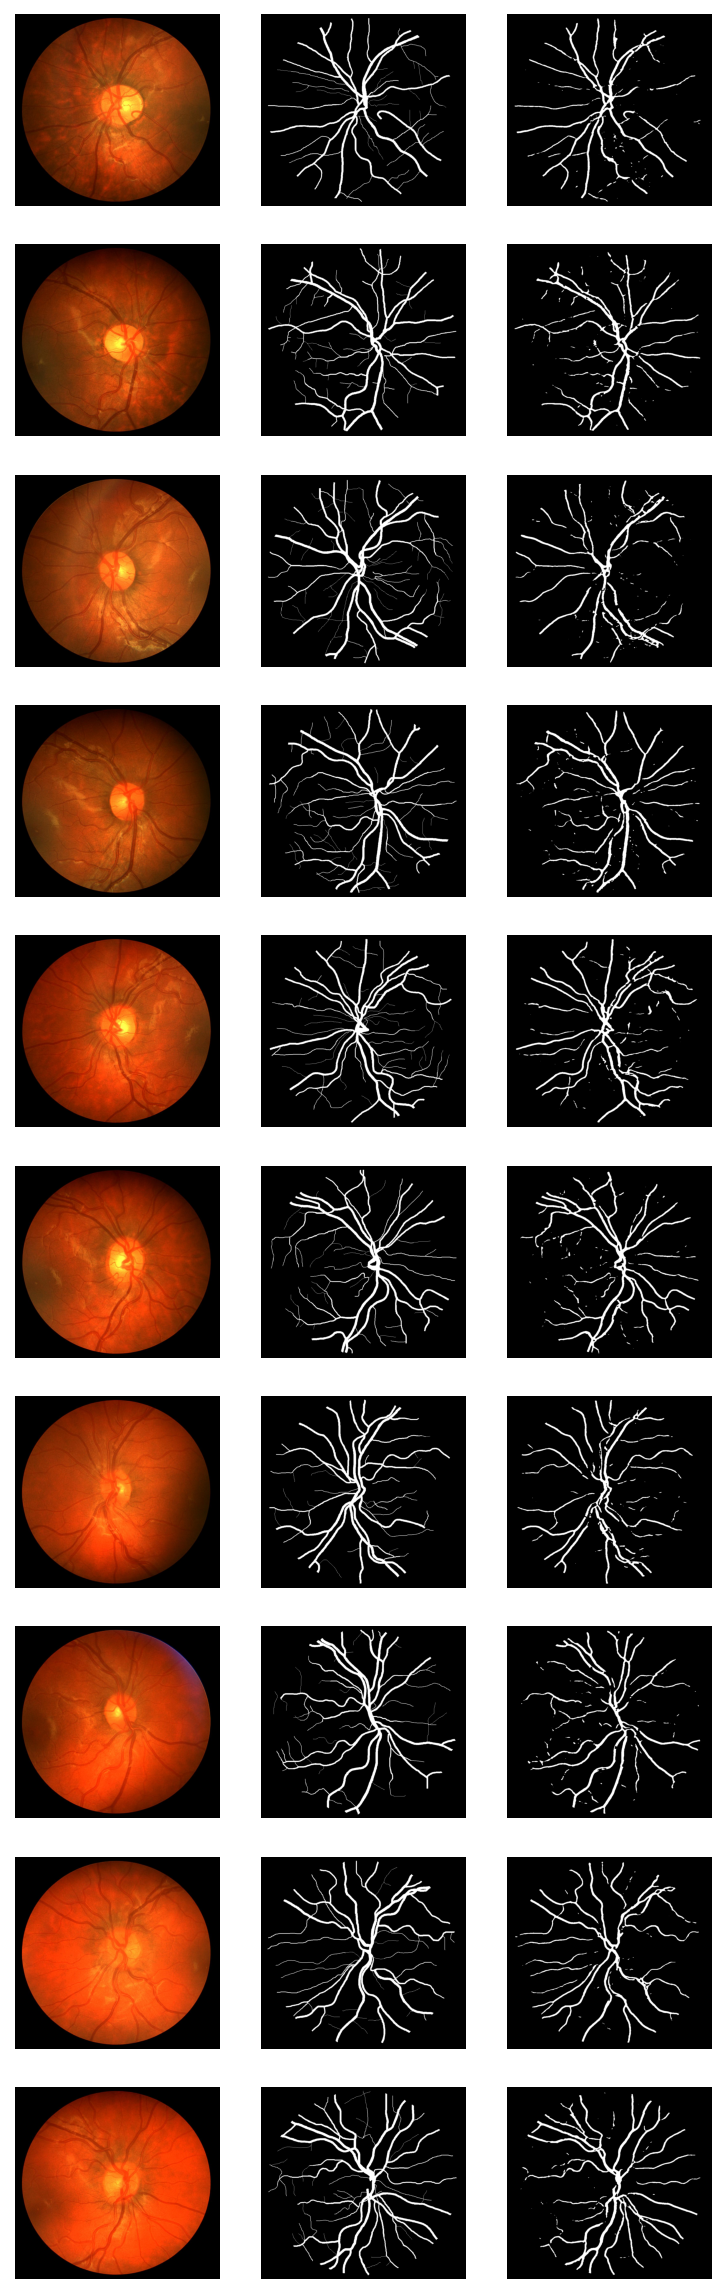

In [11]:
fig, axs = plt.subplots(10, 3, figsize=(6, 20), dpi=150)
for i, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    axs[i, 0].imshow(image)
    axs[i, 0].set_axis_off()

    axs[i, 1].imshow(label.squeeze(), cmap='gray')
    axs[i, 1].set_axis_off()

    axs[i, 2].imshow(prediction.squeeze(), cmap='gray')
    axs[i, 2].set_axis_off()